# ASSIGNMENT 4: CLASSIFICATION

Lily Huang and Shree Chatterjee

# Table of Contents
* [Introduction](#one)
* [Environment setup](#two)
* [Data setup](#three)
* [Exploratory analysis](#four)
* [Classification](#five)
    * [Naive Bayes](#a)
    * [SVM](#b)
    * [Decision Trees](#c)
    * [XGBoost](#d)
* [Ensemble](#six)
* [Final Models](#seven)

# <a class="anchor" id="one">Introduction </a>

In this project, we will be tackling a classification problem. 

Our data is associated with a clinical trial of individual subjects through different activity phases and states. There are three groups of continuous variables, which represent the x, y, and z axes of a wearable sensor worn by different subjects. 

Some of the challenges of this data set include:
* unbalanced output labels
* unseen subjects

Our strategy for this assignment is to exhaust most of the classification methods and techiques we learned in lecture. From there, we will 1) pick the individual model (each fed with the appropriate pre-processed dataset and tuned for the optimal parameters) that yields the best results, as confirmed by the Leaderboard, and 2) examine the predictions across various models to see if there is a potential blend or ensemble that can yield a higher results than is produced by 1).

Note that parts of this assignment were done in another language, R, and that the results of those programs were later fed into this notebook.

# <a class="anchor" id="two">Environment setup</a>

In this section, we will set up our working environment.

In [166]:
import pandas as pd
import numpy as np
import re
import warnings
import sys

import sklearn.linear_model
import sklearn.svm
from sklearn import metrics
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, scale, StandardScaler
from sklearn.svm import SVC 

#import xgboost as xgb

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
# configure graphics (taken from session notes)
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]
dark2_cmap = ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'
mpl.rcParams.update(mpl.rcParamsDefault)
set_mpl_params()
mpl.style.use('ggplot')

# <a class="anchor" id="three">Data setup</a> 

In this section, we will be importing and merging the training and testing sets.

In [3]:
train = pd.read_csv('data/raw_data/train_data.csv')
test = pd.read_csv('data/raw_data/test_data.csv')

In [4]:
print(train.shape)
print(test.shape)

(4584, 670)
(1732, 669)


Note that we have 4584 observations in our training set and 1732 observations in our testing set. We have 669 raw features and one outcome variable.

In [5]:
train['set'] = 'train'
test['set'] = 'test'

train_test = train.copy()
train_test.drop('output', inplace=True, axis=1)

train_test = pd.concat([train_test, test])
train_test.reset_index(inplace=True, drop=True)

From here, we did some initial data pre-processing and clean up. For one, there are a lot of redundant variables that capture no information; for example, they all have only one value. These were removed. For later models, we also one hot encoded our categorical variables, `subject`, `phase`, and `state`, as well as took the one hot encoding of their interactions. Finally, for the x, y, z variables, we took their PCA and ICA.

This part was performed in R, which handled data manipulation much more seamlessly. Please see the R script `data_setup.R` for details of our methods and procedures. We have imported the results below.

In [60]:
data = pd.read_csv('data/cleaned_data/tr_te.csv')
data_pca = pd.read_csv('data/cleaned_data/tr_te_pca.csv')
data_ica = pd.read_csv('data/cleaned_data/tr_te_ica.csv')
data_svm = pd.read_csv('data/cleaned_data/data_svm.csv')

## <a class="anchor" id="four">Exploratory analysis</a> 

In this section, we will perform some exploratory data analysis to understand the data better.

First, let us look at the distribution of subjects across the training and testing sets.

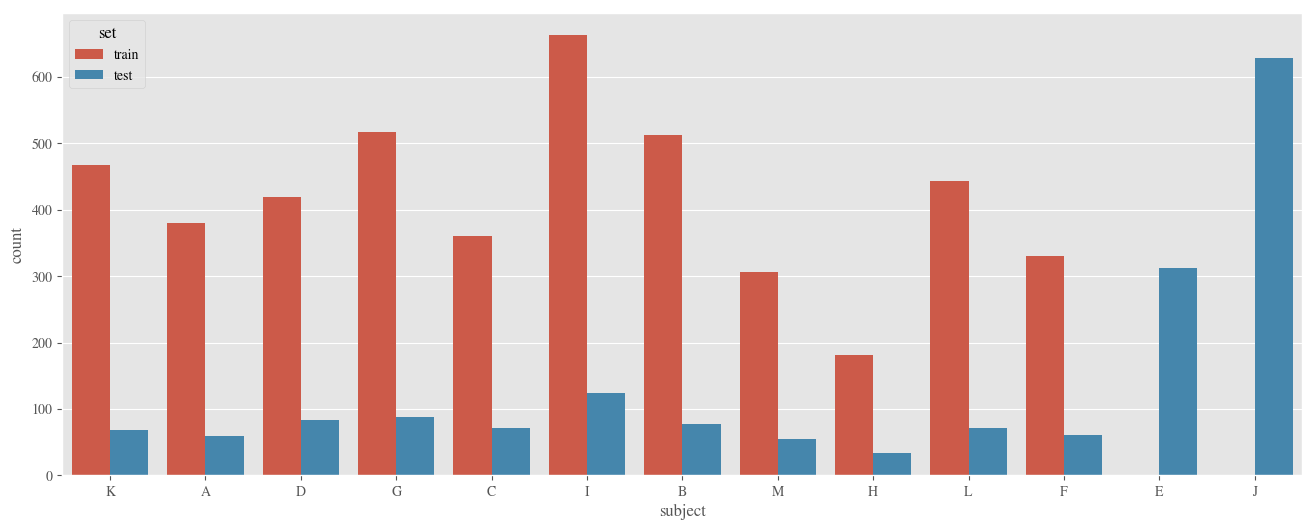

In [7]:
f, ax = plt.subplots(figsize=(16, 6))
sns.countplot(x="subject", hue="set", data=train_test)
plt.show()

We discovered that we are primarily going to be predicting for the output of subjects E and J. However, we do not actually have any observations of them in our training set.

Note that this may inflate our in-house out-of-sample testing constructed from bootstrap samples of the training set, since we will likely be overfitting in accordance to the results and behaviors of the existing subjects.

Next, let us look at the output distributions. 

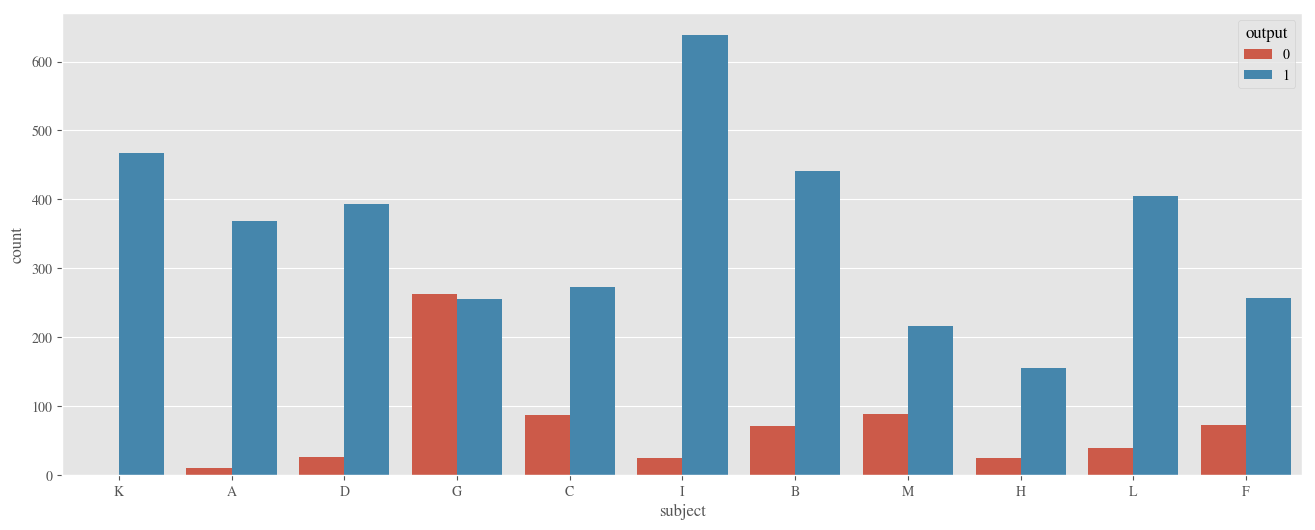

In [8]:
f, ax = plt.subplots(figsize=(16, 6))
sns.countplot(x="subject", hue="output", data=train)
plt.show()

Note that there is considerable variation for the output across subjects. For example, subject K is always a 1, whereas subject G is half-way split.

We want to now examine if there are notable differences in the sensory data between our observed subjects and our unobserved subjects (E and J). We will do this by examining the distributions on a dimension-reduced plane.

In [9]:
train_test['unseen'] = 0
train_test.loc[train_test[((train_test.subject=='E') | (train_test.subject=='J'))].index, 'unseen'] = 1

In [10]:
X = scale(np.array(train_test.iloc[:,0:666]))
pca = PCA()
pca_x = pd.DataFrame(pca.fit_transform(X)).iloc[:, 0:5]
pca_x.columns = ["PC1", "PC2", 'PC3', 'PC4', 'PC5']
pca_x['subject'] = train_test['subject']
pca_x['unseen'] = train_test['unseen']

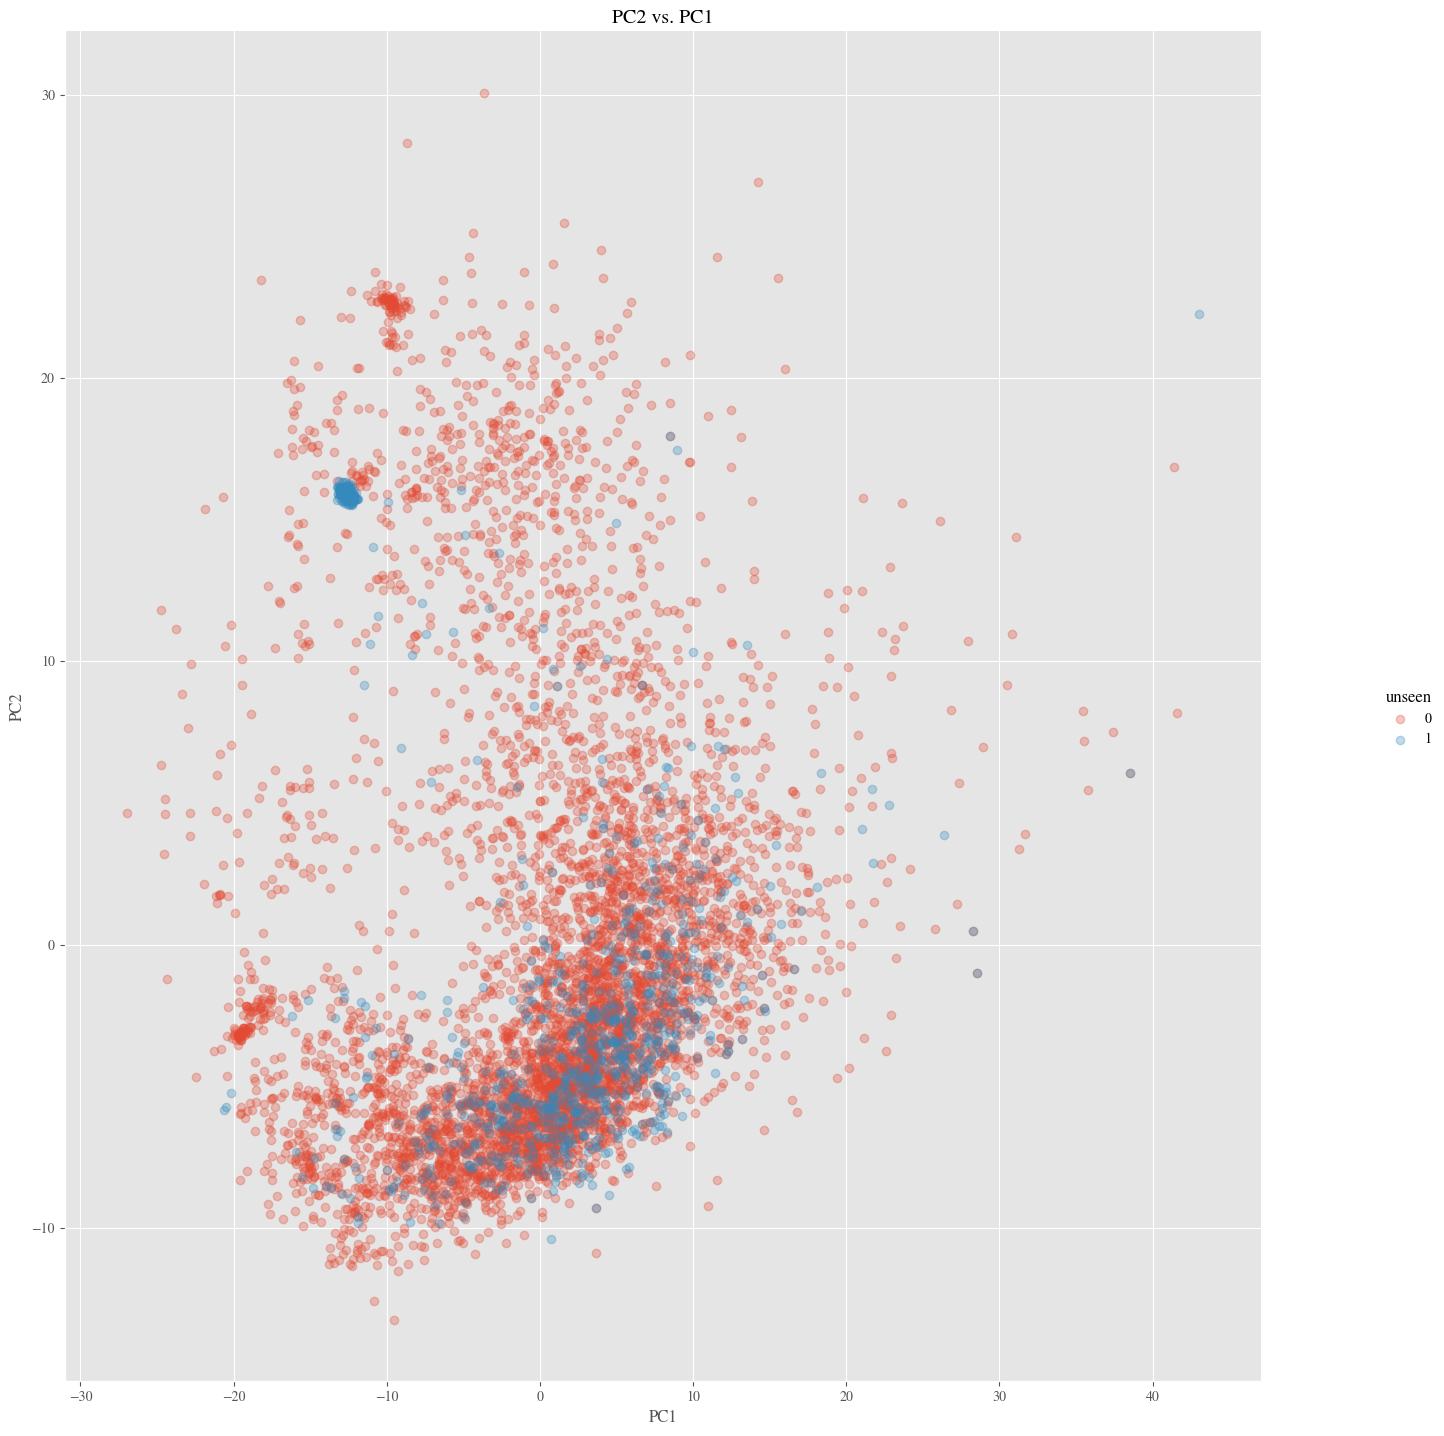

In [11]:
fig = sns.lmplot('PC1', 'PC2', data=pca_x, hue='unseen', fit_reg=False, scatter_kws={'alpha':0.3})
fig.fig.set_size_inches(16, 16)
plt.title("PC2 vs. PC1")
plt.show()

While a portion of our unseen subjects have similar sensory data our seen subjects, there is a notable cluster that deviates from the norm - note the dense upper-left cluster of unseen subjects!

While we are on PCA, we suspect that our continuous variables are highly correlated or has little information. We want to see if we can reduce the number of dimensions, which may improve the computational speed of our later models, prevent overfitting, and potentially increase accuracy.

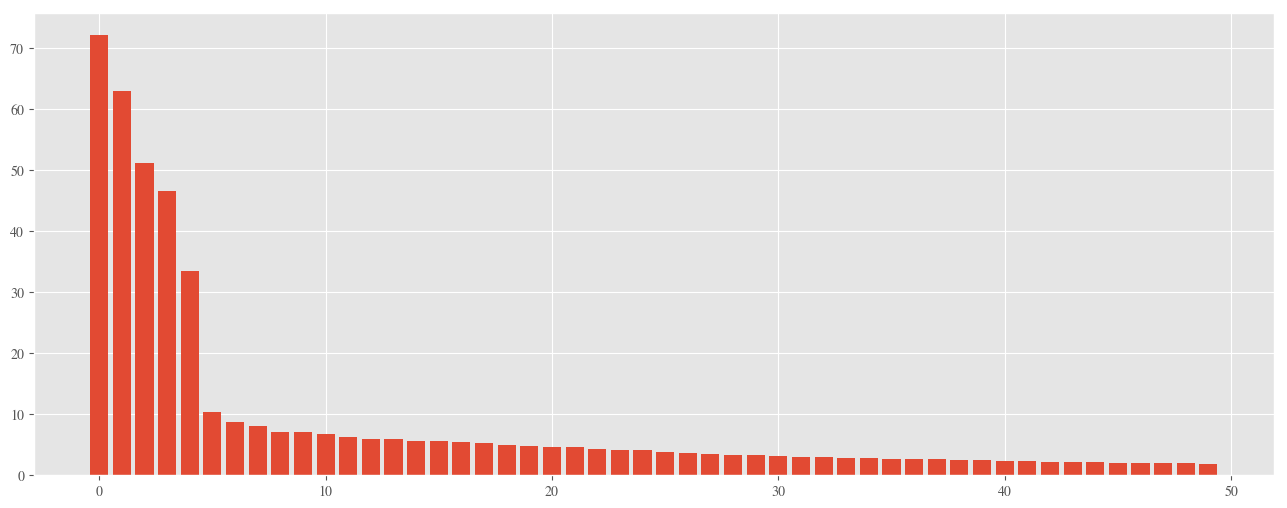

In [12]:
plt.figure(figsize=(16,6))
plt.bar(x=range(50), height=pca.explained_variance_[:50])
plt.show()

We have discovered that 99 percent of our variance can be explained within 200 components, which reduces our dimensionaliy by one-third!

# <a class="anchor" id="five">Classification</a> 

In this section, we will get to the bulk of the classification. We will go through 5 different classifiers, performing cross-validation to find the optimal parameters where necessary.

## <a class="anchor" id="a">Naive Bayes Classifiers</a> 

We will start with the Naive Bayes classifier, in which we build a conditional probability model based on Bayes' theorem and decide based on  the maximum a posteriori:

$$\hat{y} = \underset{k \in{1...k} }{argmax} \  p(C_k) \prod_{i=1}^{n} p(x_i | C_k)$$

The model assumes independence between the features. Intuitive, it would appear this assumption holds for our three categorical variables. As for the continuous x, y, z variables, we cannot make that assumption and thus took the ICA, which may theoretically break down our observed variables into mutually independent latent variables.

Unfortunately, the ICA rests on the assumption that our latent variables have a non-Gaussian distribution; when dealing with continuous data, it is typically assumed that the features are Gaussian. However, we have found that evidence that the ICA may nonetheless help:

https://link.springer.com/chapter/10.1007/978-3-540-73007-1_3

In this section, we will run two distict naive bayes classifiers.

The first is the Gaussian Naive Bayes, which we will model using only the continuous data. 

The second is the Bernoulli Naive Bayes, which we will model using only our categorical/dummy data.

In [13]:
dummy_vars = [col for col in data 
              if col.startswith('subject') or col.startswith('phase') or col.startswith('state')]
continuous_vars = [col for col in data 
                   if col.startswith('x') or col.startswith('y') or col.startswith('z')]

In [14]:
# split main dataset into training and testing
train_data = data.loc[data[np.logical_not(np.isnan(data.output))].index, :]
test_data = data.loc[data[np.isnan(data.output)].index, :].drop(['output'], axis=1)

# split training set into X and Y
train_Y = train_data['output']
train_X = train_data.drop(['output'], axis=1)

### Gaussian Naive Bayes

First, we will take the ICA. As we do not know beforehand how many components to consider, we will take them all from a range of 1 to 50 and use cross-validation to check which yields the best in-house predictive results.

In [15]:
ica_results = [FastICA(n_components=i).fit_transform(train_X[continuous_vars]) for i in range(1, 50)]

C:\ProgramData\Anaconda2\envs\py36\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [16]:
def gnb_cv(train_X, train_Y, n = 100):
    
    def trial():
        train_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace=True)
        test_index = np.setdiff1d(range(train_X.shape[0]), train_index)

        train_X_train = train_X.iloc[train_index, :]
        train_X_test = train_X.iloc[test_index, :]

        train_Y_train = train_Y.iloc[train_index]
        train_Y_test = train_Y.iloc[test_index]

        gnb = GaussianNB()
        gnb_fit = gnb.fit(train_X_train, train_Y_train)
        gnb_pred = gnb_fit.predict_proba(train_X_test)
        gnb_pred = [x[1] for x in gnb_pred]
        
        return roc_auc_score(y_true=train_Y_test, y_score=gnb_pred)
    
    return [trial() for i in range(n)]

In [17]:
gnb_results = [gnb_cv(pd.DataFrame(i), train_Y) for i in ica_results]
gnb_results_df = pd.DataFrame(gnb_results)

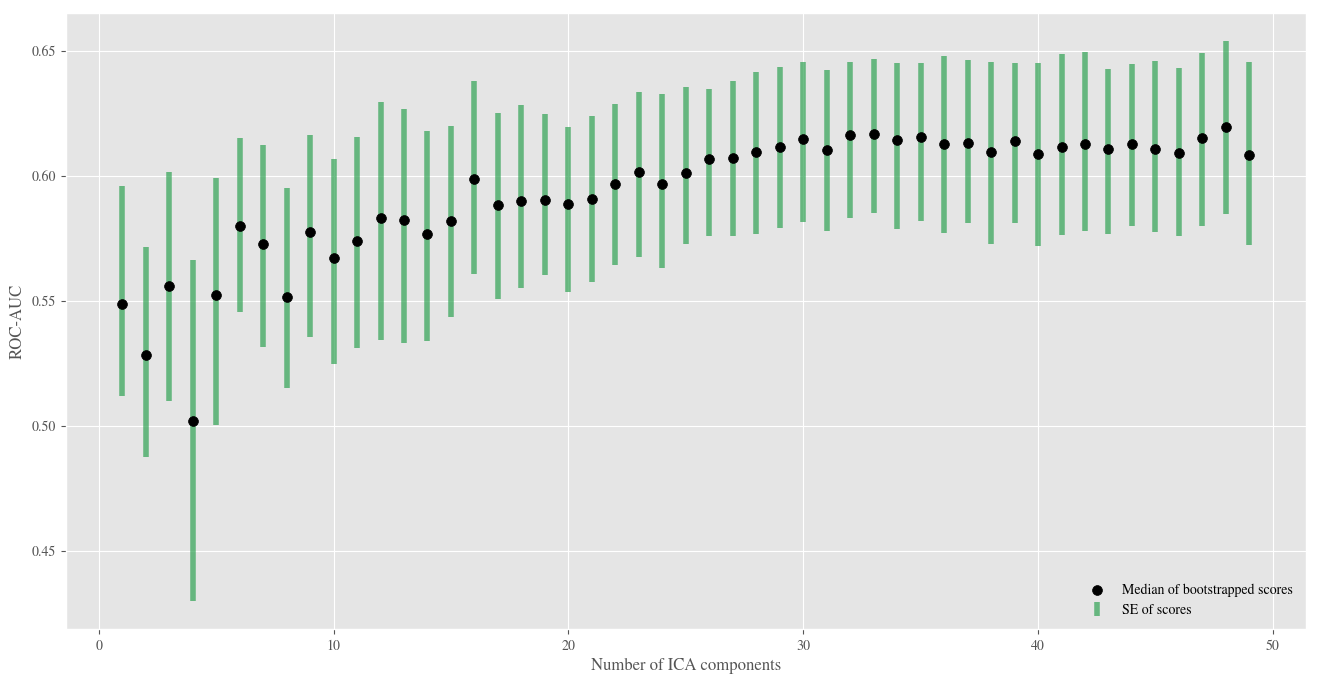

In [18]:
plt.subplots(figsize=(16,8))

ticks = range(1, 50)
score_means = gnb_results_df.mean(axis=1)
score_std = gnb_results_df.std(axis=1)
score_medians = gnb_results_df.median(axis=1)

plt.scatter(ticks, score_medians, c='k', s=50, zorder=3, label= 'Median of bootstrapped scores')
plt.errorbar(ticks, score_means, yerr = 2*score_std,color='#31a354', 
             alpha =0.7, capsize=0, elinewidth=4, linestyle="None", zorder = 1, 
             label= 'SE of scores')

plt.legend(frameon=False, loc='lower right')
plt.ylabel('ROC-AUC')
plt.xlabel('Number of ICA components')

plt.show()

For at least the in-house testing, we have a weak-classifier. Based on the scores, we decided to go with 16 components. As such, we will run the ICA again over all our available data, then fit the Gaussian Naive Bayes. Note that for the sake of robustness, we will run 100 bootstrapped trials and take the median vote.

In [52]:
data_ica = pd.DataFrame(FastICA(n_components=16).fit_transform(data[continuous_vars]))
data_ica['output'] = data['output']

train_data = data_ica.loc[data_ica[np.logical_not(np.isnan(data_ica.output))].index, :]
test_data = data_ica.loc[data_ica[np.isnan(data_ica.output)].index, :].drop(['output'], axis=1)

train_Y = train_data['output']
train_X = train_data.drop(['output'], axis=1)

In [20]:
def gnb_fit(train_X, train_Y, test_data, n = 100):
    
    def trial():
        train_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace=True)
        test_index = np.setdiff1d(range(train_X.shape[0]), train_index)

        train_X_train = train_X.iloc[train_index, :]
        train_X_test = train_X.iloc[test_index, :]

        train_Y_train = train_Y.iloc[train_index]
        train_Y_test = train_Y.iloc[test_index]

        gnb = GaussianNB()
        gnb_fit = gnb.fit(train_X_train, train_Y_train)
        gnb_pred = gnb_fit.predict_proba(test_data)
        gnb_pred = [x[1] for x in gnb_pred]
        
        return gnb_pred
    
    return [trial() for i in range(n)]

In [21]:
gnb_preds = gnb_fit(train_X, train_Y, test_data)
gnb_preds_rank = [pd.Series(i).rank() for i in gnb_preds]

gnb_pred = pd.DataFrame(gnb_preds_rank).transpose().median(axis=1)
gnb_pred = np.divide(gnb_pred, np.max(gnb_pred))

In [22]:
submission = pd.read_csv('data/raw_data/sample_solution.csv')
submission['output'] = gnb_pred
submission.to_csv('gnb.csv', index=False)

### Bernoulli Naive Bayes

Now we will repeat the above, except this time with our categorical variables.

First we will run repeated bootstraps of our training set to get an in-house ROC-AUC score.

In [43]:
def bnb_fit(train_X, train_Y, test_data, n = 100):
    
    def trial():
        train_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace=True)
        test_index = np.setdiff1d(range(train_X.shape[0]), train_index)

        train_X_train = train_X.iloc[train_index, :]
        train_X_test = train_X.iloc[test_index, :]

        train_Y_train = train_Y.iloc[train_index]
        train_Y_test = train_Y.iloc[test_index]

        bnb = BernoulliNB()
        bnb_fit = bnb.fit(train_X_train, train_Y_train)
        bnb_pred = bnb_fit.predict_proba(train_X_test)
        bnb_pred = [x[1] for x in bnb_pred]
        
        score = roc_auc_score(y_true=train_Y_test, y_score=bnb_pred)
        bnb_pred = bnb_fit.predict_proba(test_data[dummy_vars[0:20]])
        bnb_pred = [x[1] for x in bnb_pred]
        
        return score, bnb_pred
    
    return [trial() for i in range(n)]

In [44]:
# split main dataset into training and testing
train_data = data.loc[data[np.logical_not(np.isnan(data.output))].index, :]
test_data = data.loc[data[np.isnan(data.output)].index, :].drop(['output'], axis=1)

# split training set into X and Y
train_Y = train_data['output']
train_X = train_data.drop(['output'], axis=1)

bnb_results = bnb_fit(train_X[dummy_vars[0:20]], train_Y, test_data)

In [48]:
bnb_scores = [x[0] for x in bnb_results]
bnb_preds = [x[1] for x in bnb_results]

print('ROC-AUC : ', np.mean(bnb_scores))
print('Std. Dev: ', np.std(bnb_scores))

ROC-AUC :  0.8074088378877332
Std. Dev:  0.011714992559084852


For at least the in-house testing, our classifier has predictive value. However, we suspect this is prone to overfitting for the actual testing set, as much of what is driving the prediction is the subject.

Now we will retrieve the predictions for our testing set. As with above, for the sake of robustness, we will run 100 bootstrapped trials and take the median vote.

In [49]:
bnb_preds_rank = [pd.Series(i).rank() for i in bnb_preds]

bnb_pred = pd.DataFrame(bnb_preds_rank).transpose().median(axis=1)
bnb_pred = np.divide(bnb_pred, np.max(bnb_pred))

In [50]:
submission = pd.read_csv('data/raw_data/sample_solution.csv')
submission['output'] = bnb_pred
submission.to_csv('bnb.csv', index=False)

## <a class="anchor" id="a">Support Vector Machine</a> 

The next classifier we will look at is the discriminative classifier, SVM, which draws the boundary of the highest margin. Because we do not expect a linear boundary, we will be using the Gaussian kernel.
    
For SVM, we will need to tune for two parameters. These are:

* $C$: A parameter for soft margin cost function. This allows us to specify the cost of the violation to the margin. Smaller costs leads to wide margins and higher bias whereas greater costs leads to narrow margins and higher variance. 
* $\gamma$: A parameter that designates the complexity or shape; it is the parameter of the Gaussian radial basis function:

$$K(X,X') = exp\left(\gamma \left\| X-X \right\|_2^2\right)$$

For this classifier, we will be using our PCA dataset. Note that all our variables will be standardized.

In [61]:
train_data = data_svm.loc[data_svm[np.logical_not(np.isnan(data_svm.output))].index, :]
test_data = data_svm.loc[data_svm[np.isnan(data_svm.output)].index, :]
train_Y = train_data['output']
train_X = train_data.drop(['output'], axis=1)

std_scale = StandardScaler().fit(train_X)
train_X = std_scale.transform(train_X)
test_data = std_scale.transform(test_data.drop(['output'], axis=1))

Now we will perform a grid search for the optimal paramters C and $\gamma$.

In [67]:
params = {'C':[0.1, 1.0, 10, 100], 'gamma':[0.001, 0.01, 0.1], 
          'kernel':['rbf']}

gsearch = GridSearchCV(estimator=SVC(), 
                        param_grid=params, 
                        scoring='roc_auc',
                        n_jobs=4, 
                        cv=5)

gsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [0.1, 1.0, 10, 100], 'gamma': [0.001, 0.01, 0.1], 'kernel': ['rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [68]:
gsearch.best_params_, gsearch.best_score_

({'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}, 0.8613274187906337)

With our optimal paramters, we will now fit our model and make our SVM predictions.

In [73]:
# fit the model
clf = SVC(C=10, gamma=0.01, kernel='rbf', probability=True)
clf.fit(train_X, train_Y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [76]:
svm_pred = clf.predict_proba(test_data)
svm_pred = [x[1] for x in svm_pred]

In [77]:
submission = pd.read_csv('data/raw_data/sample_solution.csv')
submission['output'] = svm_pred
submission.to_csv('svm.csv', index=False)

## <a class="anchor" id="c">Decision Trees</a> 

Now we will look at different ensembles of decision trees. In particular, we will take advantage of `sklearn.ensemble` and run through the available selection: the Random Forest classifier, the Extra Trees classifier, and the AdaBoost classifier.

In [97]:
train_data = data_pca.loc[data_pca[np.logical_not(np.isnan(data_pca.output))].index, :]
test_data = data_pca.loc[data_pca[np.isnan(data_pca.output)].index, :]
train_Y = train_data['output']
train_X = train_data.drop(['output'], axis=1)

std_scale = StandardScaler().fit(train_X)
train_X = std_scale.transform(train_X)
test_data = std_scale.transform(test_data.drop(['output'], axis=1))

First, we performed a grid search for the optimal parameters of each classifier. Then we will make our predictions given the optimal parameters.

In [85]:
ntrain = train_X.shape[0]
ntest = test_data.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits= NFOLDS, shuffle=True, random_state=SEED)

class SklearnHelper:
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def predict_proba(self, x):
        return self.clf.predict_proba(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)    

In [86]:
# Random Forest
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 6,
    'min_samples_leaf': 10,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 7,
    'min_samples_leaf': 10,
    'verbose': 0
}

# AdaBoost
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

In [87]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)

In [98]:
et_oof_train, et_oof_test = get_oof(et, train_X, train_Y.values, test_data) # Extra Trees

In [99]:
rf_oof_train, rf_oof_test = get_oof(rf, train_X, train_Y.values, test_data) # Random Forest

In [100]:
ada_oof_train, ada_oof_test = get_oof(ada, train_X, train_Y.values, test_data) # AdaBoost 

In [102]:
base_predictions_train = pd.DataFrame({
    'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel()})
base_predictions_train.head()

,AdaBoost,ExtraTrees,RandomForest
0,0.519879,0.930231,0.910292
1,0.501718,0.894232,0.878528
2,0.503533,0.906931,0.877854
3,0.503792,0.557654,0.647381
4,0.503352,0.837542,0.853373


In [103]:
submission = pd.read_csv('data/raw_data/sample_solution.csv')
submission['output'] = base_predictions_train['AdaBoost']
submission.to_csv('AdaBoost.csv', index=False)

submission = pd.read_csv('data/raw_data/sample_solution.csv')
submission['output'] = base_predictions_train['ExtraTrees']
submission.to_csv('ExtraTrees.csv', index=False)

submission = pd.read_csv('data/raw_data/sample_solution.csv')
submission['output'] = base_predictions_train['RandomForest']
submission.to_csv('RandomForest.csv', index=False)

## <a class="anchor" id="d">XGBoost</a> 

Our final classifiers are from the `xgboost` package. We ran both its base tree model as well as the logistic regression. 

Please see the corresponding R scripts for the code. `model_tuning.R` performs the parameter tuning while `model_setup.R` runs the main model. Note that there is a helper script `function_setup.R`, which helps set up the data in a format ready for `xgboost`.

Our final parameters for our gradient boosted tree were `eta = 0.01`, `max_depth = 3`, `gamma = 0.1`, `colsample_bytree = 0.6`, and `scale_pos_weight = 0.18357862`.

Our final parameters for our linear model were `alpha = 0`, `lambda = 0`.

As with before, we used bootstrapping to do 20 different runs per model configuration, then took the median rank vote across the 20 results (50 in the submission run).

# <a class="anchor" id="six">Ensemble</a> 

In our final section, we will look at potential ensembles and blends.

First, we will load all our previous results.

In [152]:
models = ['ab', 'bnb', 'et', 'gnb', 'rf', 'svm', 'xgblin', 'xgbtree']

ensemble = pd.DataFrame({
    "gnb" : pd.read_csv('results/gnb.csv').output,
    "bnb" : pd.read_csv('results/bnb.csv').output,
    "svm" : pd.read_csv('results/svm.csv').output,
    "ab" : pd.read_csv('results/AdaBoost.csv').output,
    "et" : pd.read_csv('results/ExtraTrees.csv').output,
    "rf" : pd.read_csv('results/RandomForest.csv').output,
    "xgbtree" : pd.read_csv('results/xgbtree.csv').output,
    "xgblin" : pd.read_csv('results/xgblin.csv').output
})

We will take a look at the correlations across models:

In [158]:
ensemble.corr()

,ab,bnb,et,gnb,rf,svm,xgblin,xgbtree,unseen
ab,1.000000,0.003024,0.495490,0.034810,0.451312,0.004904,-0.016724,-0.006182,0.001485
bnb,0.003024,1.000000,-0.007338,0.099483,-0.008215,0.409429,0.472986,0.641723,-0.206550
et,0.495490,-0.007338,1.000000,0.005579,0.982988,0.015337,-0.014313,-0.052133,0.009823
gnb,0.034810,0.099483,0.005579,1.000000,0.012524,-0.002224,0.258154,0.149877,-0.163716
rf,0.451312,-0.008215,0.982988,0.012524,1.000000,0.014444,-0.013787,-0.053113,0.013901
svm,0.004904,0.409429,0.015337,-0.002224,0.014444,1.000000,0.257038,0.447790,0.280822
xgblin,-0.016724,0.472986,-0.014313,0.258154,-0.013787,0.257038,1.000000,0.530313,-0.429624
xgbtree,-0.006182,0.641723,-0.052133,0.149877,-0.053113,0.447790,0.530313,1.000000,-0.085467
unseen,0.001485,-0.206550,0.009823,-0.163716,0.013901,0.280822,-0.429624,-0.085467,1.000000


With the exception of RandomForest and ExtraTrees, the models are surprisingly not highly correlated amongst one another. That is good, as ensembles work best the predictions are made independently.

We will go further and examine the correlation amongst the seen and unseen subjects only.

In [155]:
ensemble['unseen'] = 0
ensemble.loc[test[((test.subject=='E') | (test.subject=='J'))].index, 'unseen'] = 1

In [159]:
ensemble.loc[ensemble.unseen == 1, models].corr()

,ab,bnb,et,gnb,rf,svm,xgblin,xgbtree
ab,1.000000,-0.045438,0.492073,-0.014770,0.452154,0.005118,0.003245,-0.060041
bnb,-0.045438,1.000000,-0.012643,-0.135891,-0.011268,0.337221,-0.141375,0.190888
et,0.492073,-0.012643,1.000000,-0.032920,0.983096,-0.037534,0.011361,-0.095462
gnb,-0.014770,-0.135891,-0.032920,1.000000,-0.019900,-0.016899,0.261648,-0.172807
rf,0.452154,-0.011268,0.983096,-0.019900,1.000000,-0.036193,0.015490,-0.093925
svm,0.005118,0.337221,-0.037534,-0.016899,-0.036193,1.000000,-0.060648,0.125274
xgblin,0.003245,-0.141375,0.011361,0.261648,0.015490,-0.060648,1.000000,0.071360
xgbtree,-0.060041,0.190888,-0.095462,-0.172807,-0.093925,0.125274,0.071360,1.000000


In [160]:
ensemble.loc[ensemble.unseen == 1, ['ab', 'gnb', 'svm', 'xgbtree']].corr()

,ab,gnb,svm,xgbtree
ab,1.000000,-0.014770,0.005118,-0.060041
gnb,-0.014770,1.000000,-0.016899,-0.172807
svm,0.005118,-0.016899,1.000000,0.125274
xgbtree,-0.060041,-0.172807,0.125274,1.000000


For unseen subjects, we removed all highly correlated models. It would appear good candidates to try a blend are AdaBoost, Gaussian Naive Bayes, SVM, and XGBoosted Tree.

In [128]:
ensemble.loc[ensemble.unseen == 0, models].corr()

,ab,bnb,et,gnb,rf,svm,xgblin,xgbtree
ab,1.000000,0.035989,0.499885,0.092213,0.450648,0.005997,-0.034613,0.029831
bnb,0.035989,1.000000,-0.001239,0.192154,-0.002181,0.549151,0.662617,0.799457
et,0.499885,-0.001239,1.000000,0.050564,0.982883,0.027864,-0.027856,-0.026521
gnb,0.092213,0.192154,0.050564,1.000000,0.052399,0.070247,0.183859,0.332559
rf,0.450648,-0.002181,0.982883,0.052399,1.000000,0.024309,-0.026270,-0.028666
svm,0.005997,0.549151,0.027864,0.070247,0.024309,1.000000,0.543045,0.572186
xgblin,-0.034613,0.662617,-0.027856,0.183859,-0.026270,0.543045,1.000000,0.740973
xgbtree,0.029831,0.799457,-0.026521,0.332559,-0.028666,0.572186,0.740973,1.000000


In [141]:
ensemble.loc[ensemble.unseen == 0, ['et', 'xgbtree']].corr()

,et,xgbtree
et,1.000000,-0.026521
xgbtree,-0.026521,1.000000


For seen subjects, the models have closer predictions to one another. For unseen subjects, we removed all highly correlated models. It would appear good candidates to try a blend are ExtraTrees and XGBoosted Tree.

With these potential selections, we then tried various combinations of blends (both seen and unseen) using the median ranked vote method. The prediction results of these can be seen in the submissions page on Kaggle.

# <a class="anchor" id="seven">Final Selected Models</a> 

After experimentation, and cross-checking with the Leaderboard score on Kaggle, we ultimately decided on the following two models.

The first is simply our optimized XGBoost model:
* Uses one-hot encodinbg for all categorical variables
* Includes complete set of interactive terms across the categorical variables
* Removes redundant variables, including those that have less than 5 counts in either training or testing
* Uses the first 200 PCA components
* Has been tuned in accordance with the highest in-housing out of sampling ROC-AUC

The first model yielded a public Leaderboard score of 0.746.

The second uses the above, blended with the Gaussian Naive Bayes on the unseen subjects only:
* Uses the GNB model, which uses 16 ICA of the continuous variables only
* Uses 2:1 weighted ranked vote (2 for XGB, 1 for GNB) on the unseen subjects only

The second model yielded a public Leaderboard score of 0.757, which at the time of this submission, is the highest score on the 50% of test data given by Kaggle.